In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt

import os
from pathlib import Path
from tqdm import tqdm
import gc

from visualisation import visualize_samples, visualize_results
from evaluation import psnr, mse, ssim
from models import SRCNN, ESPCN, SRGenerator, SRDiscriminator

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
class SuperResolutionDataset(Dataset):
    def __init__(self, hr_dir, lr_dir):
        self.hr_dir = Path(hr_dir)
        self.lr_dir = Path(lr_dir)
        
        # Get file names without extension
        self.file_names = [f.stem for f in self.hr_dir.glob("*.npy")]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        hr_path = self.hr_dir / f"{file_name}.npy"
        lr_path = self.lr_dir / f"{file_name}.npy"

        # Load .npy files
        hr_image = np.load(hr_path).astype(np.float32)
        lr_image = np.load(lr_path).astype(np.float32)

        # Convert to PyTorch tensors
        hr_image = torch.from_numpy(hr_image)  # Assuming images are (H, W, C)
        lr_image = torch.from_numpy(lr_image)

        return lr_image, hr_image

In [5]:
hr_dir = "Dataset/HR"
lr_dir = "Dataset/LR"

In [6]:
# Create dataset
dataset = SuperResolutionDataset(hr_dir, lr_dir)

# Train-test split (80-20)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Example usage
for lr, hr in train_loader:
    print(f"LR shape: {lr.shape}, HR shape: {hr.shape}")
    break

LR shape: torch.Size([16, 1, 75, 75]), HR shape: torch.Size([16, 1, 150, 150])


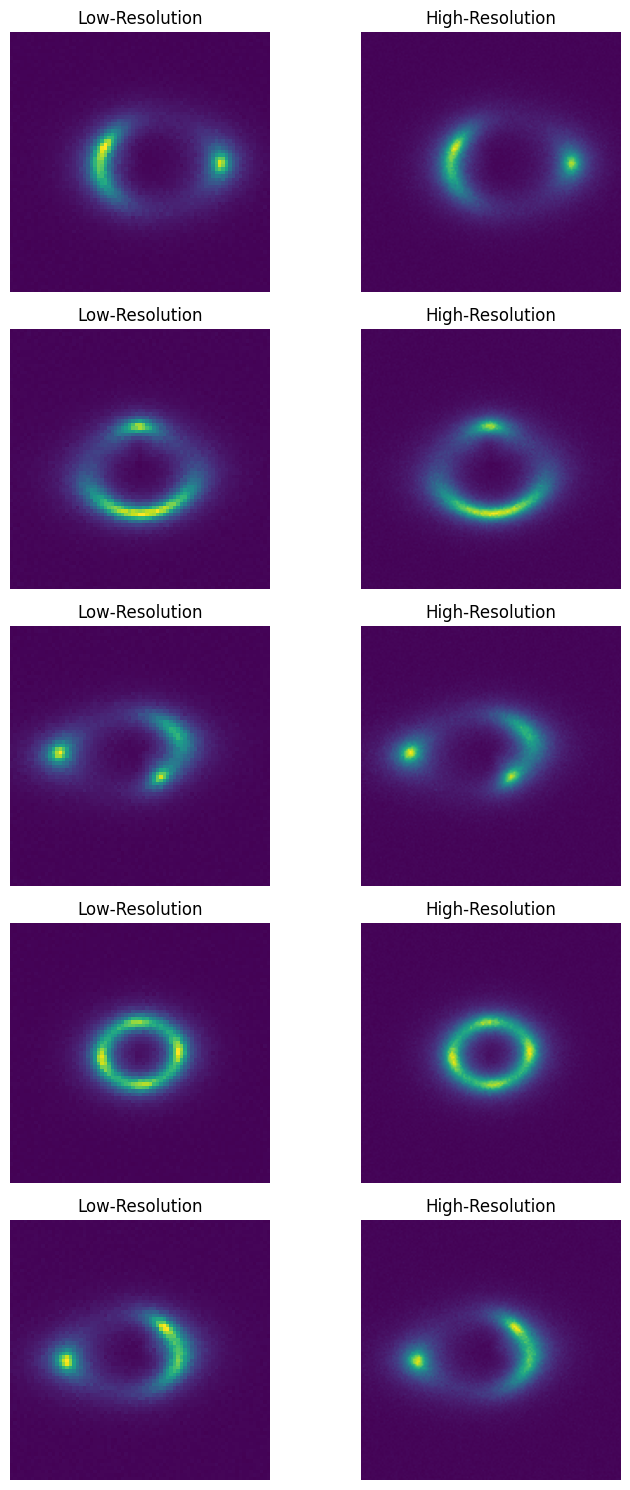

In [7]:
visualize_samples(train_loader, num_samples=5)

## SRCNN Models

In [7]:
class SRCNN(torch.nn.Module):
    def __init__(self, scale_factor, n_1, n_2, f_1, f_2, f_3):
        super(SRCNN, self).__init__()
        self.scale_factor = scale_factor
        self.patch_extractor = torch.nn.Conv2d(1, n_1, (f_1, f_1), padding='same', padding_mode='reflect')
        self.non_linear_map = torch.nn.Conv2d(n_1, n_2, (f_2, f_2), padding='same', padding_mode='reflect')
        self.reconstructor = torch.nn.Conv2d(n_2, 1, (f_3, f_3), padding='same', padding_mode='reflect')

    def forward(self, x):
        upsampled_x = F.interpolate(x, scale_factor=self.scale_factor, mode='bicubic')
        upsampled_x = self.patch_extractor(upsampled_x)
        upsampled_x = self.non_linear_map(upsampled_x)
        upsampled_x = F.relu(upsampled_x)
        upsampled_x = self.reconstructor(upsampled_x)
        return upsampled_x

In [7]:
model = SRCNN(2, 64, [32], 5, [1], 3)
model = model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50
patience = 5  # Stop training if no improvement for 5 consecutive epochs
best_val_loss = float('inf')
epochs_no_improve = 0
model_save_path = "best_sr_model.pth"  # Path to save the best model

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for lr_imgs, hr_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

        sr_imgs = model(lr_imgs)

        loss = criterion(sr_imgs, hr_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for lr_imgs, hr_imgs in test_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(lr_imgs)
            val_loss += criterion(sr_imgs, hr_imgs).item()

    avg_val_loss = val_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    # Early Stopping & Model Saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_save_path)  # Save best model
        print(f"✔ Model saved with Val Loss: {best_val_loss}")
    else:
        epochs_no_improve += 1
        print(f"❌ No improvement for {epochs_no_improve}/{patience} epochs.")

    if epochs_no_improve >= patience:
        print("⏹ Early stopping triggered!")
        break  # Stop training if no improvement for 'patience' epochs

print("✅ Training complete!")
print(f"📁 Best model saved at: {model_save_path}")

Epoch 1/50: 100%|█████████████████████████████| 500/500 [00:17<00:00, 29.30it/s]


Epoch [1/50] - Train Loss: 0.0006884586918604327, Val Loss: 9.222881420282647e-05
✔ Model saved with Val Loss: 9.222881420282647e-05


Epoch 2/50: 100%|█████████████████████████████| 500/500 [00:16<00:00, 29.87it/s]


Epoch [2/50] - Train Loss: 8.175829297397285e-05, Val Loss: 7.595274178311229e-05
✔ Model saved with Val Loss: 7.595274178311229e-05


Epoch 3/50: 100%|█████████████████████████████| 500/500 [00:16<00:00, 29.87it/s]


Epoch [3/50] - Train Loss: 7.34488536400022e-05, Val Loss: 7.160941237816587e-05
✔ Model saved with Val Loss: 7.160941237816587e-05


Epoch 4/50: 100%|█████████████████████████████| 500/500 [00:16<00:00, 29.85it/s]


Epoch [4/50] - Train Loss: 7.072502993105445e-05, Val Loss: 6.9679846172221e-05
✔ Model saved with Val Loss: 6.9679846172221e-05


Epoch 5/50: 100%|█████████████████████████████| 500/500 [00:16<00:00, 29.85it/s]


Epoch [5/50] - Train Loss: 6.856761864764849e-05, Val Loss: 6.77328475867398e-05
✔ Model saved with Val Loss: 6.77328475867398e-05


Epoch 6/50: 100%|█████████████████████████████| 500/500 [00:16<00:00, 29.89it/s]


Epoch [6/50] - Train Loss: 6.73595830303384e-05, Val Loss: 6.683890754356981e-05
✔ Model saved with Val Loss: 6.683890754356981e-05


Epoch 7/50: 100%|█████████████████████████████| 500/500 [00:16<00:00, 29.81it/s]


Epoch [7/50] - Train Loss: 6.655642135592643e-05, Val Loss: 6.61309450515546e-05
✔ Model saved with Val Loss: 6.61309450515546e-05


Epoch 8/50: 100%|█████████████████████████████| 500/500 [00:16<00:00, 29.81it/s]


Epoch [8/50] - Train Loss: 6.591280236898456e-05, Val Loss: 6.554136297199875e-05
✔ Model saved with Val Loss: 6.554136297199875e-05


Epoch 9/50: 100%|█████████████████████████████| 500/500 [00:16<00:00, 29.83it/s]


Epoch [9/50] - Train Loss: 6.535418709972873e-05, Val Loss: 6.501185419620015e-05
✔ Model saved with Val Loss: 6.501185419620015e-05


Epoch 10/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.59it/s]


Epoch [10/50] - Train Loss: 6.48553664868814e-05, Val Loss: 6.455480016302318e-05
✔ Model saved with Val Loss: 6.455480016302318e-05


Epoch 11/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.71it/s]


Epoch [11/50] - Train Loss: 6.445328627160051e-05, Val Loss: 6.421643844805658e-05
✔ Model saved with Val Loss: 6.421643844805658e-05


Epoch 12/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.60it/s]


Epoch [12/50] - Train Loss: 6.418479046260472e-05, Val Loss: 6.400836686952971e-05
✔ Model saved with Val Loss: 6.400836686952971e-05


Epoch 13/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.82it/s]


Epoch [13/50] - Train Loss: 6.401984075637301e-05, Val Loss: 6.38740055146627e-05
✔ Model saved with Val Loss: 6.38740055146627e-05


Epoch 14/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.85it/s]


Epoch [14/50] - Train Loss: 6.390878558158874e-05, Val Loss: 6.377770530525595e-05
✔ Model saved with Val Loss: 6.377770530525595e-05


Epoch 15/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.86it/s]


Epoch [15/50] - Train Loss: 6.382445334747899e-05, Val Loss: 6.370321090798825e-05
✔ Model saved with Val Loss: 6.370321090798825e-05


Epoch 16/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.82it/s]


Epoch [16/50] - Train Loss: 6.376244116836461e-05, Val Loss: 6.364545645192265e-05
✔ Model saved with Val Loss: 6.364545645192265e-05


Epoch 17/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.98it/s]


Epoch [17/50] - Train Loss: 6.37108719383832e-05, Val Loss: 6.359958756365813e-05
✔ Model saved with Val Loss: 6.359958756365813e-05


Epoch 18/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.89it/s]


Epoch [18/50] - Train Loss: 6.366906979383203e-05, Val Loss: 6.35564883123152e-05
✔ Model saved with Val Loss: 6.35564883123152e-05


Epoch 19/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.80it/s]


Epoch [19/50] - Train Loss: 6.362860915396595e-05, Val Loss: 6.351866689510644e-05
✔ Model saved with Val Loss: 6.351866689510644e-05


Epoch 20/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.83it/s]


Epoch [20/50] - Train Loss: 6.359852380410302e-05, Val Loss: 6.350368738640099e-05
✔ Model saved with Val Loss: 6.350368738640099e-05


Epoch 21/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.86it/s]


Epoch [21/50] - Train Loss: 6.356903573760064e-05, Val Loss: 6.346591675537638e-05
✔ Model saved with Val Loss: 6.346591675537638e-05


Epoch 22/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.57it/s]


Epoch [22/50] - Train Loss: 6.354605370142963e-05, Val Loss: 6.345207785489038e-05
✔ Model saved with Val Loss: 6.345207785489038e-05


Epoch 23/50: 100%|████████████████████████████| 500/500 [00:17<00:00, 29.00it/s]


Epoch [23/50] - Train Loss: 6.352381503529614e-05, Val Loss: 6.342994357692077e-05
✔ Model saved with Val Loss: 6.342994357692077e-05


Epoch 24/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.57it/s]


Epoch [24/50] - Train Loss: 6.350506098533515e-05, Val Loss: 6.346910068532452e-05
❌ No improvement for 1/5 epochs.


Epoch 25/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.46it/s]


Epoch [25/50] - Train Loss: 6.348942730983254e-05, Val Loss: 6.33912742487155e-05
✔ Model saved with Val Loss: 6.33912742487155e-05


Epoch 26/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.57it/s]


Epoch [26/50] - Train Loss: 6.34474812541157e-05, Val Loss: 6.335782571113668e-05
✔ Model saved with Val Loss: 6.335782571113668e-05


Epoch 27/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.42it/s]


Epoch [27/50] - Train Loss: 6.34089683444472e-05, Val Loss: 6.330827905912883e-05
✔ Model saved with Val Loss: 6.330827905912883e-05


Epoch 28/50: 100%|████████████████████████████| 500/500 [00:17<00:00, 28.63it/s]


Epoch [28/50] - Train Loss: 6.339017394930124e-05, Val Loss: 6.328729083179496e-05
✔ Model saved with Val Loss: 6.328729083179496e-05


Epoch 29/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.47it/s]


Epoch [29/50] - Train Loss: 6.337181904382305e-05, Val Loss: 6.327327803592198e-05
✔ Model saved with Val Loss: 6.327327803592198e-05


Epoch 30/50: 100%|████████████████████████████| 500/500 [00:17<00:00, 29.39it/s]


Epoch [30/50] - Train Loss: 6.335778665379622e-05, Val Loss: 6.326032572542317e-05
✔ Model saved with Val Loss: 6.326032572542317e-05


Epoch 31/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.43it/s]


Epoch [31/50] - Train Loss: 6.334522351971828e-05, Val Loss: 6.32729840290267e-05
❌ No improvement for 1/5 epochs.


Epoch 32/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.62it/s]


Epoch [32/50] - Train Loss: 6.33337894178112e-05, Val Loss: 6.324135171598755e-05
✔ Model saved with Val Loss: 6.324135171598755e-05


Epoch 33/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.55it/s]


Epoch [33/50] - Train Loss: 6.33247839869e-05, Val Loss: 6.322735644062049e-05
✔ Model saved with Val Loss: 6.322735644062049e-05


Epoch 34/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.47it/s]


Epoch [34/50] - Train Loss: 6.331076451169793e-05, Val Loss: 6.328783818753436e-05
❌ No improvement for 1/5 epochs.


Epoch 35/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.53it/s]


Epoch [35/50] - Train Loss: 6.330354794772574e-05, Val Loss: 6.320139515446498e-05
✔ Model saved with Val Loss: 6.320139515446498e-05


Epoch 36/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.63it/s]


Epoch [36/50] - Train Loss: 6.328995716467034e-05, Val Loss: 6.320470562786796e-05
❌ No improvement for 1/5 epochs.


Epoch 37/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.61it/s]


Epoch [37/50] - Train Loss: 6.328293916885741e-05, Val Loss: 6.31966860673856e-05
✔ Model saved with Val Loss: 6.31966860673856e-05


Epoch 38/50: 100%|████████████████████████████| 500/500 [00:17<00:00, 29.38it/s]


Epoch [38/50] - Train Loss: 6.328136727097445e-05, Val Loss: 6.318111205473542e-05
✔ Model saved with Val Loss: 6.318111205473542e-05


Epoch 39/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.63it/s]


Epoch [39/50] - Train Loss: 6.32679525151616e-05, Val Loss: 6.317390623735264e-05
✔ Model saved with Val Loss: 6.317390623735264e-05


Epoch 40/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.59it/s]


Epoch [40/50] - Train Loss: 6.326110506779514e-05, Val Loss: 6.316521906410344e-05
✔ Model saved with Val Loss: 6.316521906410344e-05


Epoch 41/50: 100%|████████████████████████████| 500/500 [00:17<00:00, 29.26it/s]


Epoch [41/50] - Train Loss: 6.325358102913015e-05, Val Loss: 6.319737469311803e-05
❌ No improvement for 1/5 epochs.


Epoch 42/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.54it/s]


Epoch [42/50] - Train Loss: 6.324748638144228e-05, Val Loss: 6.317222316283733e-05
❌ No improvement for 2/5 epochs.


Epoch 43/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.46it/s]


Epoch [43/50] - Train Loss: 6.324024445348187e-05, Val Loss: 6.3151792564895e-05
✔ Model saved with Val Loss: 6.3151792564895e-05


Epoch 44/50: 100%|████████████████████████████| 500/500 [00:17<00:00, 28.76it/s]


Epoch [44/50] - Train Loss: 6.32347267237492e-05, Val Loss: 6.31473514076788e-05
✔ Model saved with Val Loss: 6.31473514076788e-05


Epoch 45/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.71it/s]


Epoch [45/50] - Train Loss: 6.322672455280554e-05, Val Loss: 6.313822357333265e-05
✔ Model saved with Val Loss: 6.313822357333265e-05


Epoch 46/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.61it/s]


Epoch [46/50] - Train Loss: 6.322250280936714e-05, Val Loss: 6.316258932929487e-05
❌ No improvement for 1/5 epochs.


Epoch 47/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.81it/s]


Epoch [47/50] - Train Loss: 6.321835603739601e-05, Val Loss: 6.312523284577764e-05
✔ Model saved with Val Loss: 6.312523284577764e-05


Epoch 48/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.80it/s]


Epoch [48/50] - Train Loss: 6.321189443406184e-05, Val Loss: 6.31345052679535e-05
❌ No improvement for 1/5 epochs.


Epoch 49/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.84it/s]


Epoch [49/50] - Train Loss: 6.32057439579512e-05, Val Loss: 6.313246092759072e-05
❌ No improvement for 2/5 epochs.


Epoch 50/50: 100%|████████████████████████████| 500/500 [00:16<00:00, 29.80it/s]


Epoch [50/50] - Train Loss: 6.32036488968879e-05, Val Loss: 6.312114535830915e-05
✔ Model saved with Val Loss: 6.312114535830915e-05
✅ Training complete!
📁 Best model saved at: best_sr_model.pth


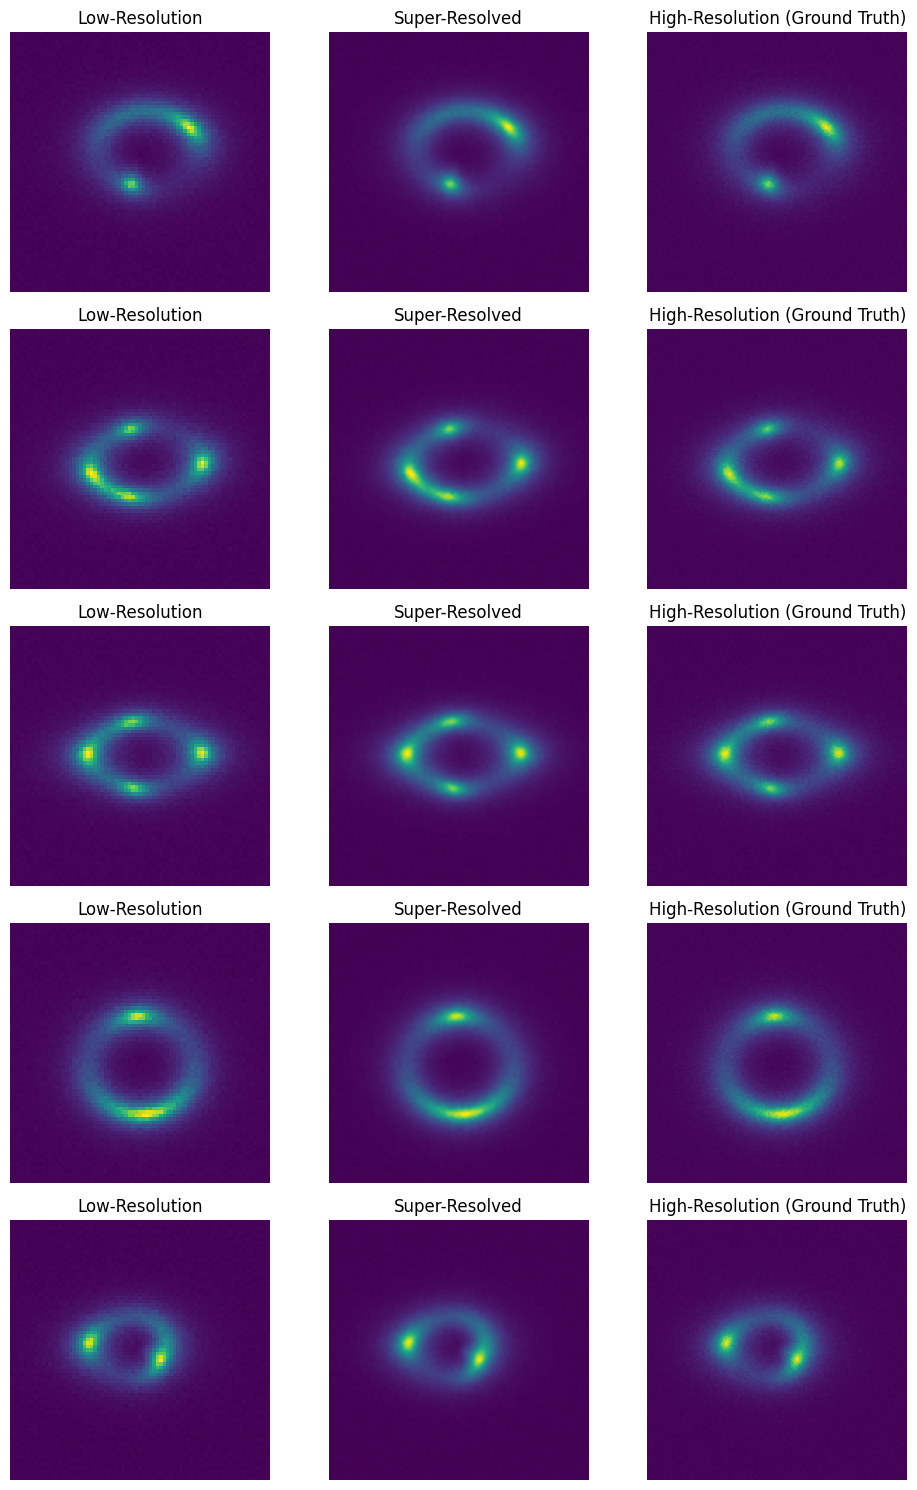

Final Evaluation - MSE: 6.323012664506678e-05, PSNR: 42.02432135735581, SSIM: 0.9742449451982975


In [9]:
model = SRCNN(2, 64, [32], 5, [1], 3)
model = model.to(device)
model_save_path = "best_sr_model.pth" 
model.load_state_dict(torch.load(model_save_path))
visualize_results(model, test_loader, num_samples=5, device=device)

model.eval()

# Evaluation loop
total_psnr, total_ssim, total_mse = 0.0, 0.0, 0.0
num_images = 0

with torch.no_grad():
    for lr_imgs, hr_imgs in test_loader:
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        sr_imgs = model(lr_imgs)  # Generate SR images

        # Compute MSE, PSNR & SSIM for each image
        for i in range(lr_imgs.shape[0]):
            total_mse += mse(sr_imgs[i], hr_imgs[i])
            total_psnr += psnr(sr_imgs[i], hr_imgs[i])
            total_ssim += ssim(sr_imgs[i].unsqueeze(0), hr_imgs[i].unsqueeze(0))
            num_images += 1

# Compute final average MSE, PSNR & SSIM
avg_mse = total_mse / num_images
avg_psnr = total_psnr / num_images
avg_ssim = total_ssim / num_images

print(f"Final Evaluation - MSE: {avg_mse}, PSNR: {avg_psnr}, SSIM: {avg_ssim}")

In [9]:
model = SRCNN(2, 32, [16], 9, [3], 5)
model = model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50
patience = 5  # Stop training if no improvement for 5 consecutive epochs
best_val_loss = float('inf')
epochs_no_improve = 0
model_save_path = "best_sr_model_2.pth"  # Path to save the best model

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for lr_imgs, hr_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

        sr_imgs = model(lr_imgs)

        loss = criterion(sr_imgs, hr_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for lr_imgs, hr_imgs in test_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(lr_imgs)
            val_loss += criterion(sr_imgs, hr_imgs).item()

    avg_val_loss = val_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    # Early Stopping & Model Saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_save_path)  # Save best model
        print(f"✔ Model saved with Val Loss: {best_val_loss}")
    else:
        epochs_no_improve += 1
        print(f"❌ No improvement for {epochs_no_improve}/{patience} epochs.")

    if epochs_no_improve >= patience:
        print("⏹ Early stopping triggered!")
        break  # Stop training if no improvement for 'patience' epochs

print("✅ Training complete!")
print(f"📁 Best model saved at: {model_save_path}")

Epoch 1/50: 100%|█████████████████████████████| 500/500 [00:14<00:00, 34.29it/s]


Epoch [1/50] - Train Loss: 0.0016956254140677628, Val Loss: 9.381522197509184e-05
✔ Model saved with Val Loss: 9.381522197509184e-05


Epoch 2/50: 100%|█████████████████████████████| 500/500 [00:14<00:00, 34.76it/s]


Epoch [2/50] - Train Loss: 8.311051393684466e-05, Val Loss: 7.792630628682672e-05
✔ Model saved with Val Loss: 7.792630628682672e-05


Epoch 3/50: 100%|█████████████████████████████| 500/500 [00:14<00:00, 34.88it/s]


Epoch [3/50] - Train Loss: 7.539247933891603e-05, Val Loss: 7.30582564137876e-05
✔ Model saved with Val Loss: 7.30582564137876e-05


Epoch 4/50: 100%|█████████████████████████████| 500/500 [00:14<00:00, 34.75it/s]


Epoch [4/50] - Train Loss: 7.159003321430647e-05, Val Loss: 7.026830536779016e-05
✔ Model saved with Val Loss: 7.026830536779016e-05


Epoch 5/50: 100%|█████████████████████████████| 500/500 [00:14<00:00, 34.65it/s]


Epoch [5/50] - Train Loss: 6.946101471839938e-05, Val Loss: 6.859668216202408e-05
✔ Model saved with Val Loss: 6.859668216202408e-05


Epoch 6/50: 100%|█████████████████████████████| 500/500 [00:14<00:00, 34.67it/s]


Epoch [6/50] - Train Loss: 6.803197704721242e-05, Val Loss: 6.737204000819475e-05
✔ Model saved with Val Loss: 6.737204000819475e-05


Epoch 7/50: 100%|█████████████████████████████| 500/500 [00:14<00:00, 34.68it/s]


Epoch [7/50] - Train Loss: 6.698236820375314e-05, Val Loss: 6.647613534005358e-05
✔ Model saved with Val Loss: 6.647613534005358e-05


Epoch 8/50: 100%|█████████████████████████████| 500/500 [00:14<00:00, 34.69it/s]


Epoch [8/50] - Train Loss: 6.621598170750076e-05, Val Loss: 6.58128485956695e-05
✔ Model saved with Val Loss: 6.58128485956695e-05


Epoch 9/50: 100%|█████████████████████████████| 500/500 [00:14<00:00, 34.67it/s]


Epoch [9/50] - Train Loss: 6.562187372765038e-05, Val Loss: 6.527050491422415e-05
✔ Model saved with Val Loss: 6.527050491422415e-05


Epoch 10/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.58it/s]


Epoch [10/50] - Train Loss: 6.511267132736975e-05, Val Loss: 6.479709866107441e-05
✔ Model saved with Val Loss: 6.479709866107441e-05


Epoch 11/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.39it/s]


Epoch [11/50] - Train Loss: 6.46606557565974e-05, Val Loss: 6.437626990373247e-05
✔ Model saved with Val Loss: 6.437626990373247e-05


Epoch 12/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.24it/s]


Epoch [12/50] - Train Loss: 6.428284446155886e-05, Val Loss: 6.404489054693841e-05
✔ Model saved with Val Loss: 6.404489054693841e-05


Epoch 13/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.07it/s]


Epoch [13/50] - Train Loss: 6.39754520743736e-05, Val Loss: 6.375966517953202e-05
✔ Model saved with Val Loss: 6.375966517953202e-05


Epoch 14/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.35it/s]


Epoch [14/50] - Train Loss: 6.372493741218932e-05, Val Loss: 6.353019189555198e-05
✔ Model saved with Val Loss: 6.353019189555198e-05


Epoch 15/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.21it/s]


Epoch [15/50] - Train Loss: 6.351670730509795e-05, Val Loss: 6.333360858843662e-05
✔ Model saved with Val Loss: 6.333360858843662e-05


Epoch 16/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.24it/s]


Epoch [16/50] - Train Loss: 6.333948206884088e-05, Val Loss: 6.33308184624184e-05
✔ Model saved with Val Loss: 6.33308184624184e-05


Epoch 17/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.39it/s]


Epoch [17/50] - Train Loss: 6.320027238689363e-05, Val Loss: 6.302541712648235e-05
✔ Model saved with Val Loss: 6.302541712648235e-05


Epoch 18/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.26it/s]


Epoch [18/50] - Train Loss: 6.306779321312206e-05, Val Loss: 6.291006805258803e-05
✔ Model saved with Val Loss: 6.291006805258803e-05


Epoch 19/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.17it/s]


Epoch [19/50] - Train Loss: 6.296608044794993e-05, Val Loss: 6.281197053613141e-05
✔ Model saved with Val Loss: 6.281197053613141e-05


Epoch 20/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.31it/s]


Epoch [20/50] - Train Loss: 6.288760688039474e-05, Val Loss: 6.273567088646814e-05
✔ Model saved with Val Loss: 6.273567088646814e-05


Epoch 21/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.35it/s]


Epoch [21/50] - Train Loss: 6.27819504661602e-05, Val Loss: 6.265381540288218e-05
✔ Model saved with Val Loss: 6.265381540288218e-05


Epoch 22/50: 100%|████████████████████████████| 500/500 [00:15<00:00, 32.92it/s]


Epoch [22/50] - Train Loss: 6.272372412058758e-05, Val Loss: 6.258841202361509e-05
✔ Model saved with Val Loss: 6.258841202361509e-05


Epoch 23/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 33.95it/s]


Epoch [23/50] - Train Loss: 6.267143831792054e-05, Val Loss: 6.257306056795642e-05
✔ Model saved with Val Loss: 6.257306056795642e-05


Epoch 24/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.32it/s]


Epoch [24/50] - Train Loss: 6.261073775385739e-05, Val Loss: 6.249721971107646e-05
✔ Model saved with Val Loss: 6.249721971107646e-05


Epoch 25/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.29it/s]


Epoch [25/50] - Train Loss: 6.255986027099425e-05, Val Loss: 6.242843909421935e-05
✔ Model saved with Val Loss: 6.242843909421935e-05


Epoch 26/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.32it/s]


Epoch [26/50] - Train Loss: 6.2518298291252e-05, Val Loss: 6.245899869827553e-05
❌ No improvement for 1/5 epochs.


Epoch 27/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.40it/s]


Epoch [27/50] - Train Loss: 6.246104252932128e-05, Val Loss: 6.235891079995781e-05
✔ Model saved with Val Loss: 6.235891079995781e-05


Epoch 28/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.33it/s]


Epoch [28/50] - Train Loss: 6.24457261437783e-05, Val Loss: 6.254610794712789e-05
❌ No improvement for 1/5 epochs.


Epoch 29/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.34it/s]


Epoch [29/50] - Train Loss: 6.240113855164963e-05, Val Loss: 6.22825825412292e-05
✔ Model saved with Val Loss: 6.22825825412292e-05


Epoch 30/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.17it/s]


Epoch [30/50] - Train Loss: 6.238323271099944e-05, Val Loss: 6.225984159391373e-05
✔ Model saved with Val Loss: 6.225984159391373e-05


Epoch 31/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.36it/s]


Epoch [31/50] - Train Loss: 6.233906241686782e-05, Val Loss: 6.224722642218694e-05
✔ Model saved with Val Loss: 6.224722642218694e-05


Epoch 32/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.17it/s]


Epoch [32/50] - Train Loss: 6.232200335216475e-05, Val Loss: 6.22135543380864e-05
✔ Model saved with Val Loss: 6.22135543380864e-05


Epoch 33/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.36it/s]


Epoch [33/50] - Train Loss: 6.231023171858397e-05, Val Loss: 6.218818243360146e-05
✔ Model saved with Val Loss: 6.218818243360146e-05


Epoch 34/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.35it/s]


Epoch [34/50] - Train Loss: 6.228515467228135e-05, Val Loss: 6.216905749170109e-05
✔ Model saved with Val Loss: 6.216905749170109e-05


Epoch 35/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 33.42it/s]


Epoch [35/50] - Train Loss: 6.225085818005028e-05, Val Loss: 6.225064452155494e-05
❌ No improvement for 1/5 epochs.


Epoch 36/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 33.70it/s]


Epoch [36/50] - Train Loss: 6.224630100041395e-05, Val Loss: 6.213971617398784e-05
✔ Model saved with Val Loss: 6.213971617398784e-05


Epoch 37/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.26it/s]


Epoch [37/50] - Train Loss: 6.22213770475355e-05, Val Loss: 6.216749898158014e-05
❌ No improvement for 1/5 epochs.


Epoch 38/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.23it/s]


Epoch [38/50] - Train Loss: 6.22161933206371e-05, Val Loss: 6.210368729080074e-05
✔ Model saved with Val Loss: 6.210368729080074e-05


Epoch 39/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.16it/s]


Epoch [39/50] - Train Loss: 6.21884471111116e-05, Val Loss: 6.208544311812147e-05
✔ Model saved with Val Loss: 6.208544311812147e-05


Epoch 40/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.32it/s]


Epoch [40/50] - Train Loss: 6.2181958113797e-05, Val Loss: 6.207376121892593e-05
✔ Model saved with Val Loss: 6.207376121892593e-05


Epoch 41/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.29it/s]


Epoch [41/50] - Train Loss: 6.216387587483041e-05, Val Loss: 6.20551127649378e-05
✔ Model saved with Val Loss: 6.20551127649378e-05


Epoch 42/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.02it/s]


Epoch [42/50] - Train Loss: 6.214929123962065e-05, Val Loss: 6.20868987753056e-05
❌ No improvement for 1/5 epochs.


Epoch 43/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.40it/s]


Epoch [43/50] - Train Loss: 6.213805668085115e-05, Val Loss: 6.203429074957967e-05
✔ Model saved with Val Loss: 6.203429074957967e-05


Epoch 44/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.32it/s]


Epoch [44/50] - Train Loss: 6.21197050131741e-05, Val Loss: 6.201331075862981e-05
✔ Model saved with Val Loss: 6.201331075862981e-05


Epoch 45/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.42it/s]


Epoch [45/50] - Train Loss: 6.211536990304012e-05, Val Loss: 6.201264224364423e-05
✔ Model saved with Val Loss: 6.201264224364423e-05


Epoch 46/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.45it/s]


Epoch [46/50] - Train Loss: 6.209556933754356e-05, Val Loss: 6.198865457554348e-05
✔ Model saved with Val Loss: 6.198865457554348e-05


Epoch 47/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 33.98it/s]


Epoch [47/50] - Train Loss: 6.206928626488661e-05, Val Loss: 6.197172121028415e-05
✔ Model saved with Val Loss: 6.197172121028415e-05


Epoch 48/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.24it/s]


Epoch [48/50] - Train Loss: 6.206504516740097e-05, Val Loss: 6.19549222465139e-05
✔ Model saved with Val Loss: 6.19549222465139e-05


Epoch 49/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 33.72it/s]


Epoch [49/50] - Train Loss: 6.203882064437494e-05, Val Loss: 6.196878215996549e-05
❌ No improvement for 1/5 epochs.


Epoch 50/50: 100%|████████████████████████████| 500/500 [00:14<00:00, 34.26it/s]


Epoch [50/50] - Train Loss: 6.203305689996341e-05, Val Loss: 6.191845235298387e-05
✔ Model saved with Val Loss: 6.191845235298387e-05
✅ Training complete!
📁 Best model saved at: best_sr_model_2.pth


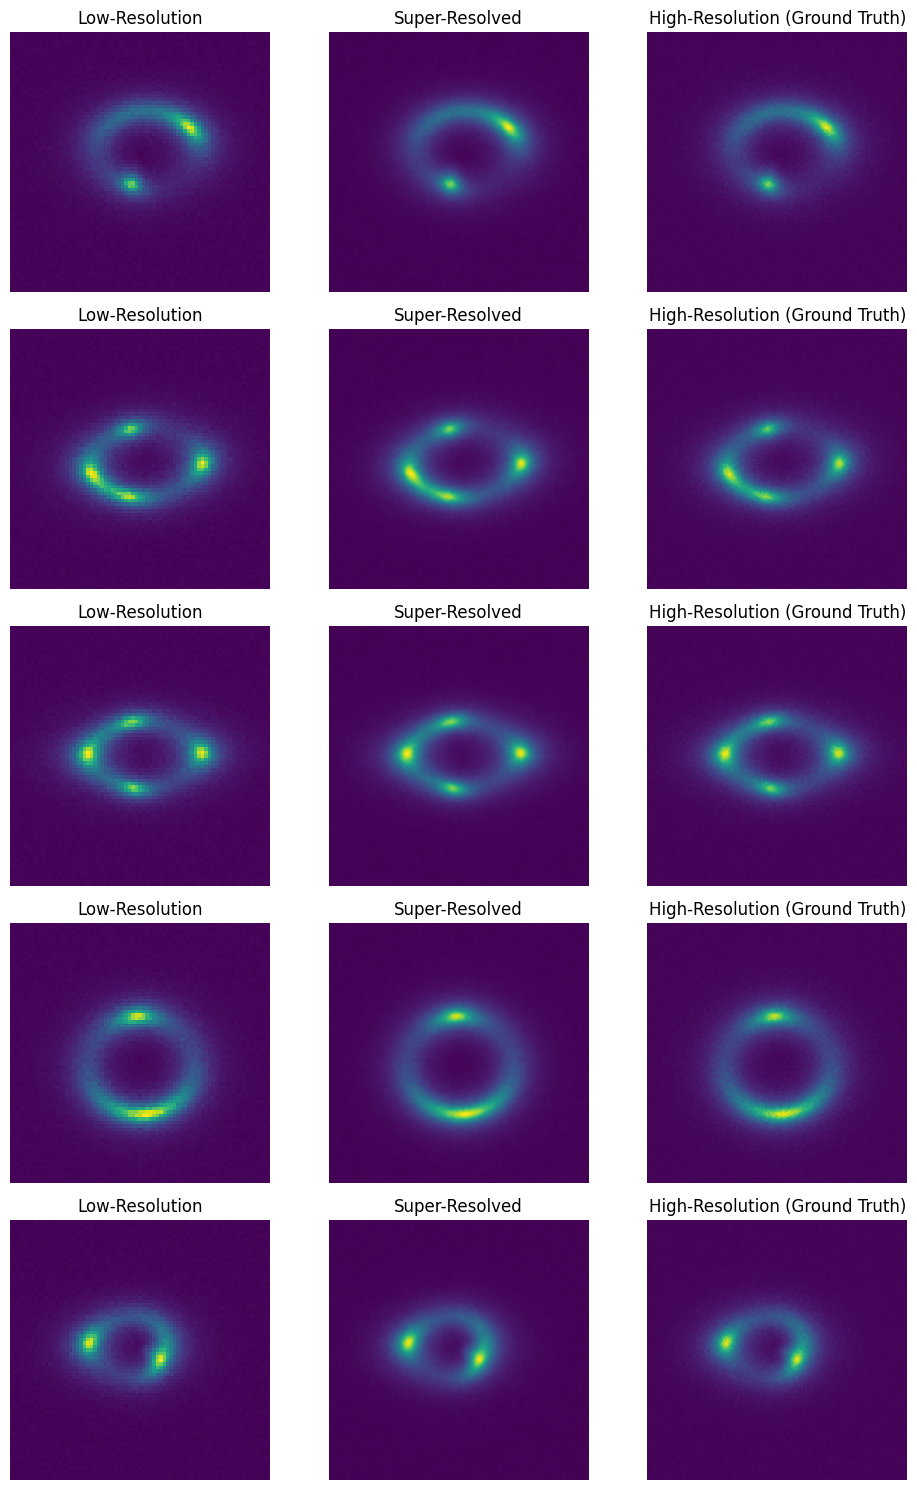

Final Evaluation - MSE: 6.202866382227513e-05, PSNR: 42.10753835349534, SSIM: 0.9746777284145355


In [11]:
model = SRCNN(2, 32, [16], 9, [3], 5)
model = model.to(device)
model_save_path = "best_sr_model_2.pth"
model.load_state_dict(torch.load(model_save_path))
visualize_results(model, test_loader, num_samples=5, device=device)

model.eval()

# Evaluation loop
total_psnr, total_ssim, total_mse = 0.0, 0.0, 0.0
num_images = 0

with torch.no_grad():
    for lr_imgs, hr_imgs in test_loader:
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        sr_imgs = model(lr_imgs)  # Generate SR images

        # Compute MSE, PSNR & SSIM for each image
        for i in range(lr_imgs.shape[0]):
            total_mse += mse(sr_imgs[i], hr_imgs[i])
            total_psnr += psnr(sr_imgs[i], hr_imgs[i])
            total_ssim += ssim(sr_imgs[i].unsqueeze(0), hr_imgs[i].unsqueeze(0))
            num_images += 1

# Compute final average MSE, PSNR & SSIM
avg_mse = total_mse / num_images
avg_psnr = total_psnr / num_images
avg_ssim = total_ssim / num_images

print(f"Final Evaluation - MSE: {avg_mse}, PSNR: {avg_psnr}, SSIM: {avg_ssim}")

## Efficient Sub Pixel Convolution Network based Super-Resolution Model

In [ ]:
model = ESPCN(kernel_sizes=[9, 7, 5, 3], inp_channels=[1, 64, 32, 16], out_channels=[64, 32, 16, 16], scale_factor=2)
model = model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50
patience = 5  # Stop training if no improvement for 5 consecutive epochs
best_val_loss = float('inf')
epochs_no_improve = 0
model_save_path = "espcn_model_1.pth"  # Path to save the best model

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for lr_imgs, hr_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

        sr_imgs = model(lr_imgs)

        loss = criterion(sr_imgs, hr_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for lr_imgs, hr_imgs in test_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = model(lr_imgs)
            val_loss += criterion(sr_imgs, hr_imgs).item()

    avg_val_loss = val_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    # Early Stopping & Model Saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_save_path)  # Save best model
        print(f"✔ Model saved with Val Loss: {best_val_loss}")
    else:
        epochs_no_improve += 1
        print(f"❌ No improvement for {epochs_no_improve}/{patience} epochs.")

    if epochs_no_improve >= patience:
        print("⏹ Early stopping triggered!")
        break  # Stop training if no improvement for 'patience' epochs

print("✅ Training complete!")
print(f"📁 Best model saved at: {model_save_path}")

Epoch 1/50: 100%|██████████| 500/500 [00:29<00:00, 17.19it/s]


Epoch [1/50] - Train Loss: 0.0007191661043761997, Val Loss: 0.00013056079583475367
✔ Model saved with Val Loss: 0.00013056079583475367


Epoch 2/50: 100%|██████████| 500/500 [00:23<00:00, 21.14it/s]


Epoch [2/50] - Train Loss: 0.0001098128001758596, Val Loss: 9.480320970760658e-05
✔ Model saved with Val Loss: 9.480320970760658e-05


Epoch 3/50: 100%|██████████| 500/500 [00:23<00:00, 21.05it/s]


Epoch [3/50] - Train Loss: 0.00010805879290273879, Val Loss: 8.633217070018872e-05
✔ Model saved with Val Loss: 8.633217070018872e-05


Epoch 4/50: 100%|██████████| 500/500 [00:23<00:00, 20.98it/s]


Epoch [4/50] - Train Loss: 8.366622707399074e-05, Val Loss: 8.075445983558894e-05
✔ Model saved with Val Loss: 8.075445983558894e-05


Epoch 5/50: 100%|██████████| 500/500 [00:23<00:00, 21.03it/s]


Epoch [5/50] - Train Loss: 7.927198588731698e-05, Val Loss: 7.660562678938732e-05
✔ Model saved with Val Loss: 7.660562678938732e-05


Epoch 6/50: 100%|██████████| 500/500 [00:23<00:00, 20.94it/s]


Epoch [6/50] - Train Loss: 7.735039442195557e-05, Val Loss: 7.422927796142175e-05
✔ Model saved with Val Loss: 7.422927796142175e-05


Epoch 7/50: 100%|██████████| 500/500 [00:23<00:00, 21.11it/s]


Epoch [7/50] - Train Loss: 7.395098159031476e-05, Val Loss: 7.11968041723594e-05
✔ Model saved with Val Loss: 7.11968041723594e-05


Epoch 8/50: 100%|██████████| 500/500 [00:23<00:00, 21.11it/s]


Epoch [8/50] - Train Loss: 7.186518373782746e-05, Val Loss: 7.732692867284641e-05
❌ No improvement for 1/5 epochs.


Epoch 9/50: 100%|██████████| 500/500 [00:23<00:00, 21.06it/s]


Epoch [9/50] - Train Loss: 6.903538611368277e-05, Val Loss: 6.728289354941808e-05
✔ Model saved with Val Loss: 6.728289354941808e-05


Epoch 10/50: 100%|██████████| 500/500 [00:23<00:00, 21.10it/s]


Epoch [10/50] - Train Loss: 6.744466086820467e-05, Val Loss: 6.581564614316449e-05
✔ Model saved with Val Loss: 6.581564614316449e-05


Epoch 11/50: 100%|██████████| 500/500 [00:23<00:00, 21.10it/s]


Epoch [11/50] - Train Loss: 6.587569175462704e-05, Val Loss: 6.669555706321261e-05
❌ No improvement for 1/5 epochs.


Epoch 12/50: 100%|██████████| 500/500 [00:23<00:00, 21.09it/s]


Epoch [12/50] - Train Loss: 6.468538355693454e-05, Val Loss: 6.33765050151851e-05
✔ Model saved with Val Loss: 6.33765050151851e-05


Epoch 13/50: 100%|██████████| 500/500 [00:23<00:00, 21.07it/s]


Epoch [13/50] - Train Loss: 6.381948540365556e-05, Val Loss: 6.319351179990918e-05
✔ Model saved with Val Loss: 6.319351179990918e-05


Epoch 14/50: 100%|██████████| 500/500 [00:23<00:00, 21.04it/s]


Epoch [14/50] - Train Loss: 6.291336901631438e-05, Val Loss: 6.353531894274057e-05
❌ No improvement for 1/5 epochs.


Epoch 15/50: 100%|██████████| 500/500 [00:23<00:00, 21.05it/s]


Epoch [15/50] - Train Loss: 6.247403732413659e-05, Val Loss: 6.135879017529078e-05
✔ Model saved with Val Loss: 6.135879017529078e-05


Epoch 16/50: 100%|██████████| 500/500 [00:23<00:00, 21.05it/s]


Epoch [16/50] - Train Loss: 6.182174893910996e-05, Val Loss: 6.237523184972815e-05
❌ No improvement for 1/5 epochs.


Epoch 17/50: 100%|██████████| 500/500 [00:23<00:00, 21.05it/s]


Epoch [17/50] - Train Loss: 6.158379746921128e-05, Val Loss: 6.0696045780787245e-05
✔ Model saved with Val Loss: 6.0696045780787245e-05


Epoch 18/50: 100%|██████████| 500/500 [00:23<00:00, 21.07it/s]


Epoch [18/50] - Train Loss: 6.125001094915205e-05, Val Loss: 6.631721075973473e-05
❌ No improvement for 1/5 epochs.


Epoch 19/50: 100%|██████████| 500/500 [00:23<00:00, 21.06it/s]


Epoch [19/50] - Train Loss: 6.104110768501415e-05, Val Loss: 6.0395354172214865e-05
✔ Model saved with Val Loss: 6.0395354172214865e-05


Epoch 20/50: 100%|██████████| 500/500 [00:23<00:00, 21.04it/s]


Epoch [20/50] - Train Loss: 6.096734318998642e-05, Val Loss: 6.179015123052523e-05
❌ No improvement for 1/5 epochs.


Epoch 21/50: 100%|██████████| 500/500 [00:23<00:00, 21.07it/s]


Epoch [21/50] - Train Loss: 6.069874366221484e-05, Val Loss: 6.0033593093976376e-05
✔ Model saved with Val Loss: 6.0033593093976376e-05


Epoch 22/50: 100%|██████████| 500/500 [00:23<00:00, 21.05it/s]


Epoch [22/50] - Train Loss: 6.063068396179006e-05, Val Loss: 6.40213726728689e-05
❌ No improvement for 1/5 epochs.


Epoch 23/50: 100%|██████████| 500/500 [00:23<00:00, 21.02it/s]


Epoch [23/50] - Train Loss: 6.042325741873355e-05, Val Loss: 5.981703053112142e-05
✔ Model saved with Val Loss: 5.981703053112142e-05


Epoch 24/50: 100%|██████████| 500/500 [00:23<00:00, 21.04it/s]


Epoch [24/50] - Train Loss: 6.0285941573965826e-05, Val Loss: 5.987303639994934e-05
❌ No improvement for 1/5 epochs.


Epoch 25/50: 100%|██████████| 500/500 [00:23<00:00, 21.06it/s]


Epoch [25/50] - Train Loss: 6.023878363339463e-05, Val Loss: 6.03152361290995e-05
❌ No improvement for 2/5 epochs.


Epoch 26/50: 100%|██████████| 500/500 [00:23<00:00, 21.04it/s]


Epoch [26/50] - Train Loss: 6.0119635447335896e-05, Val Loss: 6.211122224340215e-05
❌ No improvement for 3/5 epochs.


Epoch 27/50: 100%|██████████| 500/500 [00:23<00:00, 21.06it/s]


Epoch [27/50] - Train Loss: 6.906225252896547e-05, Val Loss: 6.047722266521305e-05
❌ No improvement for 4/5 epochs.


Epoch 28/50: 100%|██████████| 500/500 [00:23<00:00, 21.04it/s]


Epoch [28/50] - Train Loss: 6.0036485716409516e-05, Val Loss: 5.98020343168173e-05
✔ Model saved with Val Loss: 5.98020343168173e-05


Epoch 29/50: 100%|██████████| 500/500 [00:23<00:00, 20.98it/s]


Epoch [29/50] - Train Loss: 5.981282475113403e-05, Val Loss: 5.97349246381782e-05
✔ Model saved with Val Loss: 5.97349246381782e-05


Epoch 30/50: 100%|██████████| 500/500 [00:23<00:00, 21.09it/s]


Epoch [30/50] - Train Loss: 5.979932107584318e-05, Val Loss: 5.980742891551927e-05
❌ No improvement for 1/5 epochs.


Epoch 31/50: 100%|██████████| 500/500 [00:23<00:00, 20.93it/s]


Epoch [31/50] - Train Loss: 5.989671235874994e-05, Val Loss: 5.977840200648643e-05
❌ No improvement for 2/5 epochs.


Epoch 32/50: 100%|██████████| 500/500 [00:23<00:00, 20.95it/s]


Epoch [32/50] - Train Loss: 5.9871774872590324e-05, Val Loss: 5.9669561858754605e-05
✔ Model saved with Val Loss: 5.9669561858754605e-05


Epoch 33/50: 100%|██████████| 500/500 [00:24<00:00, 20.74it/s]


Epoch [33/50] - Train Loss: 5.986396249500103e-05, Val Loss: 5.9460724500240756e-05
✔ Model saved with Val Loss: 5.9460724500240756e-05


Epoch 34/50: 100%|██████████| 500/500 [00:23<00:00, 20.89it/s]


Epoch [34/50] - Train Loss: 5.978128095739521e-05, Val Loss: 5.958821356762201e-05
❌ No improvement for 1/5 epochs.


Epoch 35/50: 100%|██████████| 500/500 [00:23<00:00, 20.94it/s]


Epoch [35/50] - Train Loss: 5.971618015610147e-05, Val Loss: 5.937962594907731e-05
✔ Model saved with Val Loss: 5.937962594907731e-05


Epoch 36/50: 100%|██████████| 500/500 [00:23<00:00, 20.92it/s]


Epoch [36/50] - Train Loss: 5.979663910693489e-05, Val Loss: 5.93733636487741e-05
✔ Model saved with Val Loss: 5.93733636487741e-05


Epoch 37/50: 100%|██████████| 500/500 [00:23<00:00, 21.04it/s]


Epoch [37/50] - Train Loss: 5.953309850156074e-05, Val Loss: 5.9669490350643174e-05
❌ No improvement for 1/5 epochs.


Epoch 38/50: 100%|██████████| 500/500 [00:23<00:00, 21.13it/s]


Epoch [38/50] - Train Loss: 5.9541116585023704e-05, Val Loss: 5.9374671429395675e-05
❌ No improvement for 2/5 epochs.


Epoch 39/50: 100%|██████████| 500/500 [00:23<00:00, 21.14it/s]


Epoch [39/50] - Train Loss: 5.95481585842208e-05, Val Loss: 5.9567836724454535e-05
❌ No improvement for 3/5 epochs.


Epoch 40/50: 100%|██████████| 500/500 [00:23<00:00, 21.15it/s]


Epoch [40/50] - Train Loss: 7.128806586842984e-05, Val Loss: 6.130882012075744e-05
❌ No improvement for 4/5 epochs.


Epoch 41/50: 100%|██████████| 500/500 [00:23<00:00, 21.11it/s]


Epoch [41/50] - Train Loss: 6.0149019642267376e-05, Val Loss: 5.96786220849026e-05
❌ No improvement for 5/5 epochs.
⏹ Early stopping triggered!
✅ Training complete!
📁 Best model saved at: espcn_model_1.pth


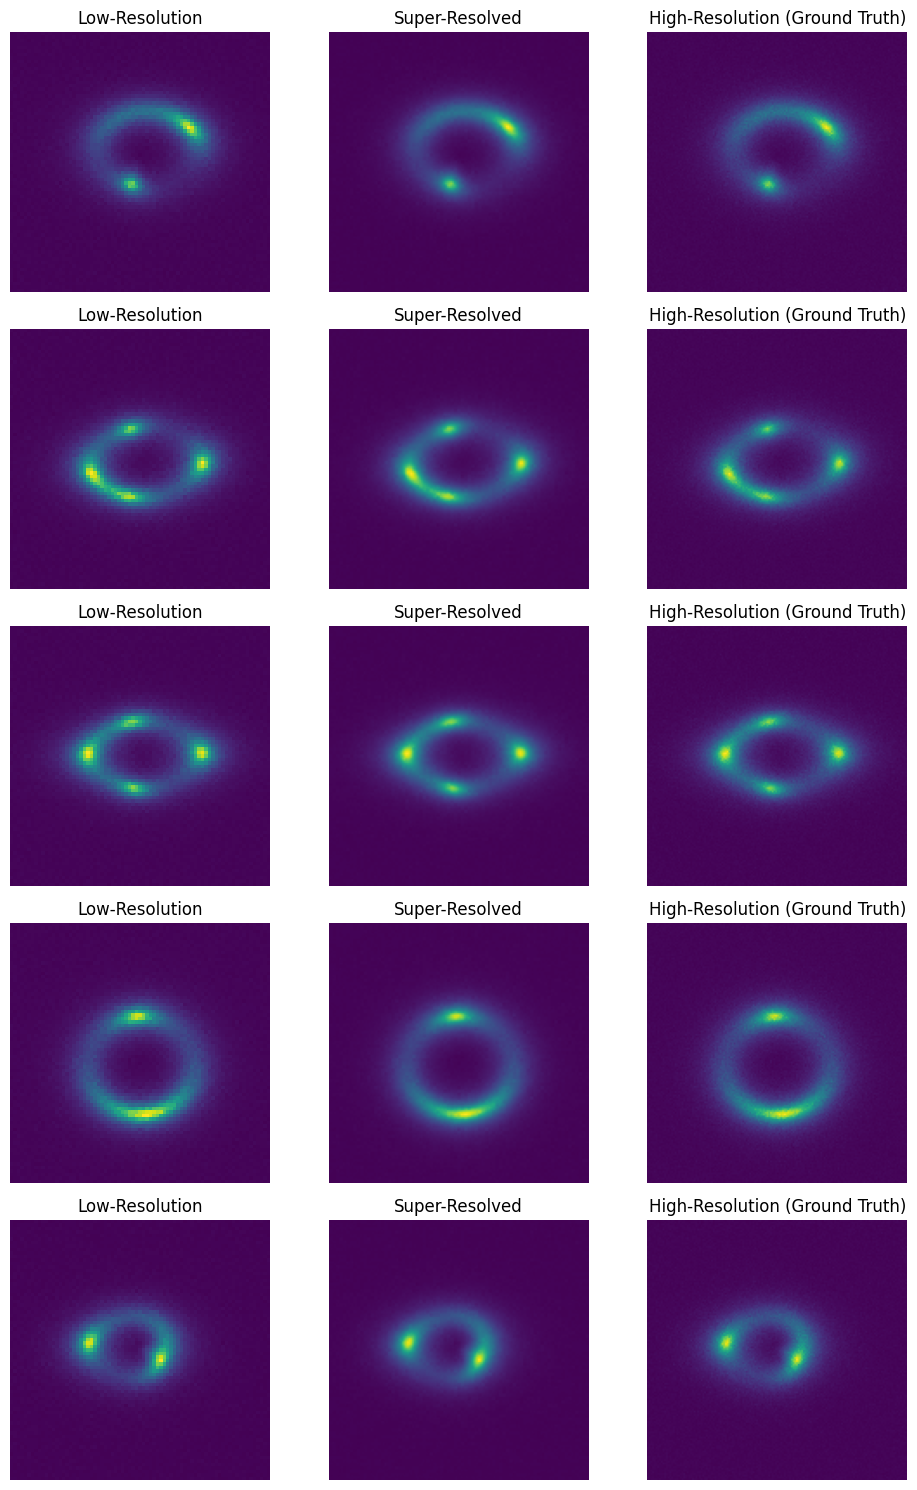

Final Evaluation - MSE: 5.9474619660250026e-05, PSNR: 42.29001581543741, SSIM: 0.9757997679710388


In [13]:
model = ESPCN(kernel_sizes=[9, 7, 5, 3], inp_channels=[1, 64, 32, 16], out_channels=[64, 32, 16, 16], scale_factor=2)
model = model.to(device)
model_save_path = "espcn_model_1.pth"  
model.load_state_dict(torch.load(model_save_path))
visualize_results(model, test_loader, num_samples=5, device=device)

model.eval()

# Evaluation loop
total_psnr, total_ssim, total_mse = 0.0, 0.0, 0.0
num_images = 0

with torch.no_grad():
    for lr_imgs, hr_imgs in test_loader:
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        sr_imgs = model(lr_imgs)  # Generate SR images

        # Compute MSE, PSNR & SSIM for each image
        for i in range(lr_imgs.shape[0]):
            total_mse += mse(sr_imgs[i], hr_imgs[i])
            total_psnr += psnr(sr_imgs[i], hr_imgs[i])
            total_ssim += ssim(sr_imgs[i].unsqueeze(0), hr_imgs[i].unsqueeze(0))
            num_images += 1

# Compute final average MSE, PSNR & SSIM
avg_mse = total_mse / num_images
avg_psnr = total_psnr / num_images
avg_ssim = total_ssim / num_images

print(f"Final Evaluation - MSE: {avg_mse}, PSNR: {avg_psnr}, SSIM: {avg_ssim}")

## SRGAN Model

In [7]:
criterion_mse = torch.nn.MSELoss()
criterion_bce = torch.nn.BCEWithLogitsLoss()

def content_loss(hr, sr):
    return criterion_mse(hr, sr)

def adversarial_loss(discriminator, sr):
    real_labels = torch.ones(sr.size(0), 1).to(device)
    return criterion_bce(discriminator(sr), real_labels)

In [10]:
generator_model = SRGenerator(1, 64, (3, 3), (9, 9), 4, upscale_factor=2).to(device)
discriminator = SRDiscriminator(
    [1, 64, 128, 256], 
    [64, 128, 256, 512], 
    [3 for i in range(4)]
    ).to(device)

num_epochs = 20
patience = 5  # Stop training if no improvement for 5 consecutive epochs
best_val_loss = float('inf')
epochs_no_improve = 0
model_save_path = "srgan_model_1.pth"  # Path to save the best model

optim_g = torch.optim.Adam(generator_model.parameters())
optim_d = torch.optim.Adam(discriminator.parameters())

for epoch in range(num_epochs):
    generator_model.train()
    discriminator.train()
    total_loss = 0.0

    for lr_imgs, hr_imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

        # Train Generator
        optim_g.zero_grad()
        sr_imgs = generator_model(lr_imgs)
        loss_content = content_loss(hr_imgs, sr_imgs)
        loss_adv = adversarial_loss(discriminator, sr_imgs)
        loss_g = loss_content + 1e-3 * loss_adv
        loss_g.backward()
        optim_g.step()

        # Train Discriminator
        optim_d.zero_grad()
        real_loss = adversarial_loss(discriminator, hr_imgs)
        fake_loss = adversarial_loss(discriminator, sr_imgs.detach())
        loss_d = real_loss + fake_loss
        loss_d.backward()
        optim_d.step()

        total_loss += loss_g.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation step
    generator_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for lr_imgs, hr_imgs in test_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            sr_imgs = generator_model(lr_imgs)
            val_loss += content_loss(sr_imgs, hr_imgs).item()

    avg_val_loss = val_loss / len(test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

    # Early Stopping & Model Saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(generator_model.state_dict(), model_save_path)  # Save best model
        print(f"✔ Model saved with Val Loss: {best_val_loss}")
    else:
        epochs_no_improve += 1
        print(f"❌ No improvement for {epochs_no_improve}/{patience} epochs.")

    if epochs_no_improve >= patience:
        print("⏹ Early stopping triggered!")
        break  # Stop training if no improvement for 'patience' epochs

print("✅ Training complete!")
print(f"📁 Best model saved at: {model_save_path}")

Epoch 1/20: 100%|██████████| 500/500 [04:56<00:00,  1.69it/s]


Epoch [1/20] - Train Loss: 0.003796219650306739, Val Loss: 0.00016224974545184522
✔ Model saved with Val Loss: 0.00016224974545184522


Epoch 2/20: 100%|██████████| 500/500 [04:56<00:00,  1.68it/s]


Epoch [2/20] - Train Loss: 0.000519038965110667, Val Loss: 0.00011469325318466871
✔ Model saved with Val Loss: 0.00011469325318466871


Epoch 3/20: 100%|██████████| 500/500 [04:56<00:00,  1.68it/s]


Epoch [3/20] - Train Loss: 0.00047489169717300684, Val Loss: 0.0001082529600826092
✔ Model saved with Val Loss: 0.0001082529600826092


Epoch 4/20: 100%|██████████| 500/500 [04:56<00:00,  1.68it/s]


Epoch [4/20] - Train Loss: 0.0004839070218731649, Val Loss: 8.99493137258105e-05
✔ Model saved with Val Loss: 8.99493137258105e-05


Epoch 5/20: 100%|██████████| 500/500 [04:56<00:00,  1.69it/s]


Epoch [5/20] - Train Loss: 0.0004752236528438516, Val Loss: 0.00035744870803318916
❌ No improvement for 1/5 epochs.


Epoch 6/20: 100%|██████████| 500/500 [04:56<00:00,  1.68it/s]


Epoch [6/20] - Train Loss: 0.00046516562229953706, Val Loss: 0.0001084482300793752
❌ No improvement for 2/5 epochs.


Epoch 7/20: 100%|██████████| 500/500 [04:57<00:00,  1.68it/s]


Epoch [7/20] - Train Loss: 0.0004747127019800246, Val Loss: 0.000159312863368541
❌ No improvement for 3/5 epochs.


Epoch 8/20: 100%|██████████| 500/500 [04:57<00:00,  1.68it/s]


Epoch [8/20] - Train Loss: 0.0004705589659861289, Val Loss: 0.00011458686820697039
❌ No improvement for 4/5 epochs.


Epoch 9/20: 100%|██████████| 500/500 [04:56<00:00,  1.68it/s]


Epoch [9/20] - Train Loss: 0.0004541980062494986, Val Loss: 0.00018633844389114528
❌ No improvement for 5/5 epochs.
⏹ Early stopping triggered!
✅ Training complete!
📁 Best model saved at: srgan_model_1.pth


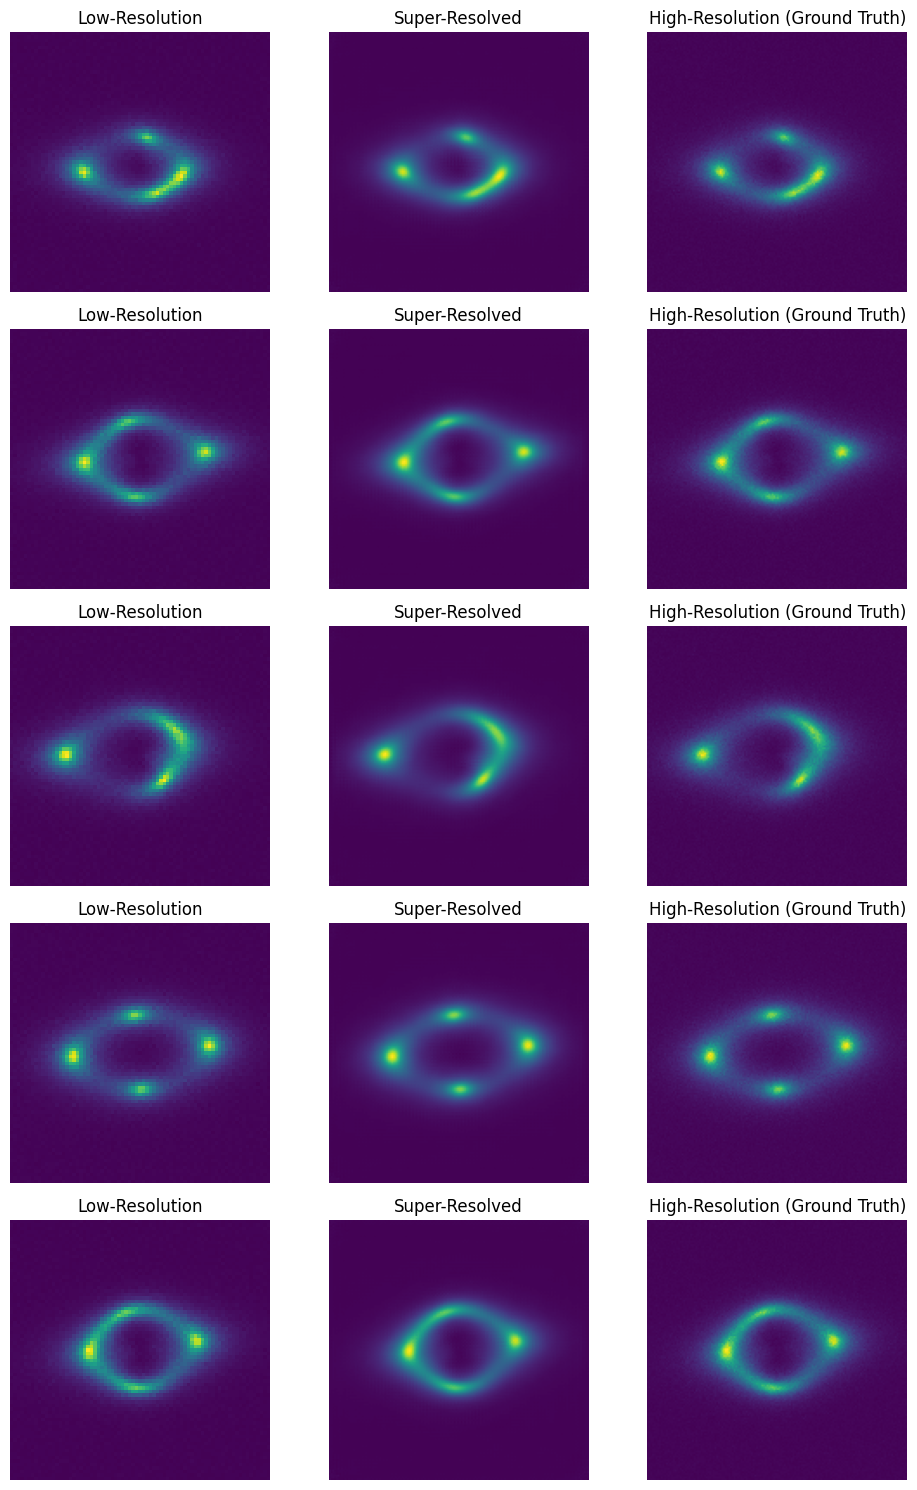

Final Evaluation - MSE: 8.994931430424913e-05, PSNR: 40.491123756170786, SSIM: 0.9586916912794113


In [11]:
model = SRGenerator(1, 64, (3, 3), (9, 9), 4, upscale_factor=2).to(device)
model = model.to(device)
model_save_path = "srgan_model_1.pth"
model.load_state_dict(torch.load(model_save_path))
visualize_results(model, test_loader, num_samples=5, device=device)

model.eval()

# Evaluation loop
total_psnr, total_ssim, total_mse = 0.0, 0.0, 0.0
num_images = 0

with torch.no_grad():
    for lr_imgs, hr_imgs in test_loader:
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        sr_imgs = model(lr_imgs)  # Generate SR images

        # Compute MSE, PSNR & SSIM for each image
        for i in range(lr_imgs.shape[0]):
            total_mse += mse(sr_imgs[i], hr_imgs[i])
            total_psnr += psnr(sr_imgs[i], hr_imgs[i])
            total_ssim += ssim(sr_imgs[i].unsqueeze(0), hr_imgs[i].unsqueeze(0))
            num_images += 1

# Compute final average MSE, PSNR & SSIM
avg_mse = total_mse / num_images
avg_psnr = total_psnr / num_images
avg_ssim = total_ssim / num_images

print(f"Final Evaluation - MSE: {avg_mse}, PSNR: {avg_psnr}, SSIM: {avg_ssim}")